# Reinforcement Learning on CartPole and MountainCar using Deep Q Learning

# Introduction

In this project, Deep-Q Learning has been used to solve two OpenAI Environments. CartPole and MountainCar. 
At first, a vanilla Deep-Q Network (DQN) has been used to train both the environments. Furter, Double DQN which is an improvement over vanilla DQN has been used to solve the CartPole environment which results in an improvement.

# Deep Q Network

A Deep Q Network is essentially just a neural network. Either a CNN is used or a traditional fully connected simple neural network (which has been used as DQN in the current project). The state of the environment is sent as input to the DQN and it gives out Q values associated with the all the actions that can be taken by the agent at that state. These Q values are approximated and over time, the DQN learns the Q function to give out optimal q values that will be estimated by the Bellman Equations

# Experience Replay


Experience Replay is the process of storing a tuple (state, action, reward, next_state) in a replay buffer and  random sample from this buffer is used to train the DQN. This is used to seperate the learning experience from the gaining experience. If the algorithm learnt from sequential data, there would be high correlation between the consequent states and action and to avoid this Experience Replay is used.

# Target Network

In Bellman Optimality Equation shown below, Target value is to be calculated. In the target value, there are 2 terms, the immediate reward and the expected reward that can be got in the future by being in that state. Hence, the second part of the target value required the next_state to be passed into the neural network. If we use a single neural network, and make two forward passes (one forward pass with state value to obtain action, and second pass with next_state value from the experience tuple) leads to overestimation of state and action values leading to unstable training.

Therefore, we use another identical network and pass the next_state values through it instead of the policy network. This new identical network is called target network. And using this brings a stability in training. The weigts of the target networks are set to the weights of policy network after every few iterations and will only be used for evaluation and not training.

<img src="./Q_learning_equation.PNG">

# 1.1 Implementation of  Vanilla DQN

In [1]:
%matplotlib inline
import gym
import time
import math
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torch.nn.functional as F
from collections import namedtuple
from itertools import count
from IPython import display

#in order to show graphs dynamically change with each episode
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

In [2]:
class DQN_Simple(nn.Module):
    def __init__(self, width, height, action_space):
        super().__init__()
        
        self.dense1 = nn.Linear(in_features=width*height*3, out_features=24)
        self.dense2 = nn.Linear(in_features=24, out_features=32)
        
        self.out = nn.Linear(in_features=32, out_features=action_space)
    
    def forward(self, features):
        features = features.flatten(start_dim=1)
        features = F.relu(self.dense1(features))
        features = F.relu(self.dense2(features))
        features = self.out(features)
        return features

In [3]:
Experience = namedtuple('Experience', ('state', 'action', 'next_state', 'reward'))
class ReplayMemory():
    def __init__(self, mem_capacity):
        self.mem_capacity = mem_capacity
        self.replay_memory = []
        self.push_count = 0
    
    #retuns a random sample of size=batch_size for the training of the DQN
    def sample(self, batch_size):
        return random.sample(self.replay_memory, batch_size)
    
    #once the replay_memory buffer is full, we remove older experiences to make space for new ones
    def push(self, experience):
        if len(self.replay_memory) < self.mem_capacity:
            self.replay_memory.append(experience)
        else:
            self.replay_memory[self.push_count % self.mem_capacity] = experience
        self.push_count += 1
    
    #to check if replay_memory is large enough to provide a sample of batch_size without repeating experience tuples
    def is_large_enough(self, batch_size):
        return len(self.replay_memory) >= batch_size

In [4]:
class Agent():
    def __init__(self, e_start, e_end, e_decay, num_actions, device):
        self.current_step = 0
        self.e_start = e_start
        self.e_decay = e_decay
        self.e_end = e_end
        self.num_actions = num_actions
        self.device = device

    def get_epsilon_greedy_strategy(self, current_step):
        #Calculates the epsilon value for the exploration vs. exploitation trade-off
         return self.e_end + (self.e_start - self.e_end) * math.exp(-1. * current_step * self.e_decay)
        
    def select_action(self, state, policy_net):
        
        rate = self.get_epsilon_greedy_strategy(self.current_step)
        self.current_step += 1

        if rate > random.random():
            action = random.randrange(self.num_actions)
            # randomly chooses an action to explore      
            return torch.tensor([action]).to(self.device) 
        else:
            # passes the state through dqn and chooses max q value (exploitation)
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(self.device)

In [5]:
class Env_Manager():
    def __init__(self, device, environment):
        self.device = device
        self.env = gym.make(environment).unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
    
    def reset(self):
        self.env.reset()
        self.current_screen = None
        
    def close(self):
        self.env.close()
        
    def render(self, mode='human'):
        return self.env.render(mode)
        
    def num_actions_available(self):
        return self.env.action_space.n
    
    #function that actually implmenets the action in the emulator and gives back a reward 
    def step(self, action):        
        _, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)
    
    #the beginning state is considered to be a black screen, hence this function to check
    def is_first_state(self):
        return self.current_screen is None
    
    def get_state(self):    
        if self.is_first_state() or self.done:
            #starting and ending state of an episode is considered a black screen
            self.current_screen = self.get_screen()
            #create black_screen with dimensions of current screen
            black_screen = np.zeros((self.current_screen.shape[0],self.current_screen.shape[1], self.current_screen.shape[2], self.current_screen.shape[3]))
            #conver Screen to tensor
            black_screen = torch.tensor(black_screen, device=self.device)
            return black_screen
        
        else:
            s1 = self.current_screen
            s2 = self.get_screen()
            self.current_screen = s2
            #instead of representing a state as stack of screenshots, a state is represented as difference between 2 screenshots
            #before and after taking the action
            return s2 - s1
    
    def get_screen_height(self):
        screen = self.get_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_screen()
        return screen.shape[3]
       
    def get_screen(self):
        #transpose is done to make the screen matrix compatible with TORCHVISION which accepts images in formar(Channels X Width X Height)
        screen = self.render('rgb_array').transpose((2, 0, 1))
        
        #reduce the size to improve computation speed
        return self.transform_screenshot(screen)
    
    def transform_screenshot(self, screen):       
        #make screen as a tensor
        screen = np.array(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        
        # Reducing size for faster computation
        resized_screen = T.Compose([T.ToPILImage(),T.Resize((50,50)),T.ToTensor()])
        
        return resized_screen(screen).unsqueeze(0).to(self.device) # add a batch dimension (BCHW)
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod        
    def get_next(policy_net, next_states):
        
        #before passing next_states into a neural network we check for terminal states and do not pass them for calculating maxq*(next_state)
        final_state_locations = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to('cuda')
        values[non_final_state_locations] = policy_net(non_final_states).max(dim=1)[0].detach()
        
        values = policy_net(next_states).max(dim=1)[0].detach()
        return values

In [6]:
def plot(values, average_rewards):
    plt.figure(2)
    plt.clf()        
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)
    plt.plot(average_rewards)
    print(f"Number of Episodes:{len(values)}\n")
    print(f"Average Duration Per Episode:{average_rewards[-1]}")
    plt.pause(0.01)
    if is_ipython: display.clear_output(wait=True)

In [7]:
def get_batches(experiences):
    batch = Experience(*zip(*experiences))
    state = torch.cat(batch.state)
    action = torch.cat(batch.action)
    reward = torch.cat(batch.reward)
    next_state = torch.cat(batch.next_state)
    return (state,action,reward,next_state)

In [8]:
batch_size = 256
gamma = 0.999
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.09
target_update = 10
memory_size = 1000
lr = 0.01
num_episodes = 300
MAX_TIME_PER_EPISODE = 3000

In [9]:
def start_playing(environment):
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    manager = Env_Manager(DEVICE,environment)
    agent = Agent(eps_start, eps_end, eps_decay, manager.num_actions_available(), DEVICE)
    memory = ReplayMemory(memory_size)

    #single network used for both current_q_value and max_q_value of next state (for bellman equation)
    policy_net = DQN_Simple(manager.get_screen_height(), manager.get_screen_width(), manager.num_actions_available()).to(DEVICE)


    optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

    episode_durations = []
    average_rewards = []
    for episode in range(num_episodes):
        manager.reset()
        state = manager.get_state()

        for timestep in count():
            action = agent.select_action(state.float(), policy_net)
            reward = manager.step(action)
            next_state = manager.get_state()
            memory.push(Experience(state.float(), action, next_state.float(), reward))
            state = next_state

            if memory.is_large_enough(batch_size):
    #           print("Started Training .... Got enoug batch size")
                experiences = memory.sample(batch_size)
                states, actions, rewards, next_states = get_batches(experiences)
                #single dqn (policy_net) used for both current and next q value prediction. Weight updates done after 2 forward passes.
                current_q_values = manager.get_current(policy_net, states, actions)
                next_q_values = manager.get_next(policy_net, next_states)
                target_q_values = (next_q_values * gamma) + rewards

                loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if manager.done:
                episode_durations.append(timestep)
                average_rewards.append(np.mean(episode_durations))
                plot(episode_durations, average_rewards)
                break

            if timestep>MAX_TIME_PER_EPISODE:
                break

    #     if episode % target_update == 0:
    #         target_net.load_state_dict(policy_net.state_dict())

    manager.close()

In [10]:
def start_playing_DDQN(environment):
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    manager = Env_Manager(DEVICE,environment)
    agent = Agent(eps_start, eps_end, eps_decay, manager.num_actions_available(), DEVICE)
    memory = ReplayMemory(memory_size)


    #two networks used for current_q_value and max_q_value of next state (for bellman equation)
    policy_net = DQN_Simple(manager.get_screen_height(), manager.get_screen_width(), manager.num_actions_available()).to(DEVICE)
    target_net = DQN_Simple(manager.get_screen_height(), manager.get_screen_width(), manager.num_actions_available()).to(DEVICE)

    #target network is used to 
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

    episode_durations = []
    average_rewards = []
    for episode in range(num_episodes):
        manager.reset()
        state = manager.get_state()

        for timestep in count():
            action = agent.select_action(state.float(), policy_net)
            reward = manager.step(action)
            next_state = manager.get_state()
            memory.push(Experience(state.float(), action, next_state.float(), reward))
            state = next_state

            if memory.is_large_enough(batch_size):
                experiences = memory.sample(batch_size)
                states, actions, rewards, next_states = get_batches(experiences)
                #single dqn (policy_net) used for current q_value 
                # target dqn next q value prediction. Weight updates done after 2 forward passes.
                current_q_values = manager.get_current(policy_net, states, actions)
                next_q_values = manager.get_next(target_net, next_states)
                target_q_values = (next_q_values * gamma) + rewards

                loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if manager.done:
                episode_durations.append(timestep)
                average_rewards.append(np.mean(episode_durations))
                plot(episode_durations, average_rewards)
                break

        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

    manager.close()

# Results

In [11]:
batch_size = 256
gamma = 0.999
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 1000
lr = 0.001
num_episodes = 25
MAX_TIME_PER_EPISODE = 3000

### 1.2 MountainCar using Vanilla DQN

###  Note: If the notebook is executed from the beginning. The actual learning of the agent inside the environment can be seen in a pop-up window

Number of Episodes:13

Average Duration Per Episode:570.7692307692307


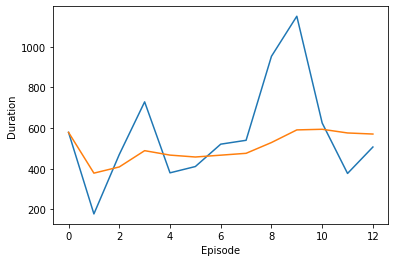

In [12]:
start_playing('MountainCar-v0')

### 1.2 CartPole Using Vanilla DQN

In [13]:
batch_size = 256
gamma = 0.999
eps_start = 0.99
eps_end = 0.01
eps_decay = 0.09
target_update = 10
memory_size = 1000
lr = 0.1
num_episodes = 500
MAX_TIME_PER_EPISODE = 3000

Number of Episodes:500

Average Duration Per Episode:10.98


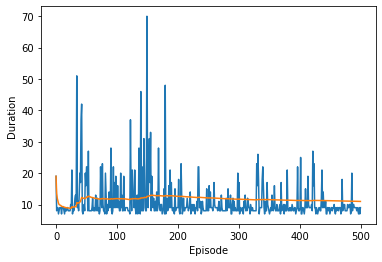

In [14]:
start_playing('CartPole-v0')

### 2. CartPole using Double DQN 

In [15]:
batch_size = 256
gamma = 0.999
eps_start = 0.99
eps_end = 0.01
eps_decay = 0.09
target_update = 10
memory_size = 1000
lr = 0.01
num_episodes = 500
MAX_TIME_PER_EPISODE = 3000

Number of Episodes:500

Average Duration Per Episode:12.33


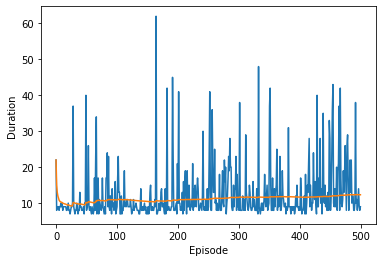

In [16]:
start_playing_DDQN('CartPole-v0')

# Conclusions

As seen above in the results for CartPole, the average duration per episode the **Vanilla DQN** could balance was **10.98** but in an improved  version of the DQN i.e **Double DQN** the average duration per episode was **12.33** when the agent played a total of 500 episodes.. The difference will be much more if the model is trained for more number of episodes and if hyperparameters are tuned.